In [70]:
# Step 1: Imports and Drive Mount
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# Step 2: Define paths
img_dir = '/content/drive/MyDrive/Images'
meta_path = '/content/Metadata_Participants.csv'

In [72]:
# Step 3: Load and preprocess metadata
metadata = pd.read_csv(meta_path)

# Keep relevant columns
metadata = metadata[['ParticipantID', 'Gender', 'Age', 'Class', 'CARS Score']]
metadata['Gender'] = metadata['Gender'].map({'M': 1, 'F': 0})
metadata['Class'] = metadata['Class'].map({'TS': 1, 'TC': 0})

# Rename for convenience
metadata.rename(columns={
    'ParticipantID': 'Participant_ID',
    'Class': 'Group',
    'CARS Score': 'CARS'
}, inplace=True)
metadata = metadata.dropna(subset=['CARS']).copy()

In [73]:
# Step 4: Load images and match with metadata
image_data = []
meta_data = []
labels = []

img_height, img_width = 128, 128

# Image loading and metadata matching (fix here)
for cls_folder in ['TCImages', 'TSImages']:
    folder_path = os.path.join(img_dir, cls_folder)
    label = 0 if cls_folder == 'TCImages' else 1

    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            parts = filename.split('_')
            pid = int(parts[1].split('.')[0])

            # Check metadata first
            row = metadata[metadata['Participant_ID'] == pid]
            if not row.empty:
                # Process image only if metadata exists
                path = os.path.join(folder_path, filename)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_width, img_height))
                img = img / 255.0

                # Append after validation
                image_data.append(img)
                meta = row[['Age', 'Gender', 'CARS']].values[0]
                meta_data.append(meta)
                labels.append(label)


In [74]:
# Step 5: Convert to NumPy arrays and normalize
image_data = np.array(image_data).reshape(-1, img_height, img_width, 1)
meta_data = np.array(meta_data)
labels = np.array(labels)

# Normalize metadata
scaler = MinMaxScaler()
meta_data = scaler.fit_transform(meta_data)

# Convert labels to float32 (important for loss function)
labels = labels.astype('float32')

# Check for NaNs
assert not np.isnan(image_data).any(), "NaNs found in image data"
assert not np.isnan(meta_data).any(), "NaNs found in metadata"

In [75]:
# Step 6: Train/test split
X_img_train, X_img_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    image_data, meta_data, labels, test_size=0.2, random_state=42)

In [76]:
# Step 7: Compute class weights for imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.astype(int)
)
class_weights = dict(enumerate(class_weights))


In [77]:
# Step 8: Build multi-input model
# Image branch
img_input = Input(shape=(img_height, img_width, 1), name='image_input')
x = layers.Conv2D(32, (3, 3), activation='relu')(img_input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
img_out = layers.Dropout(0.5)(x)

# Metadata branch
meta_input = Input(shape=(3,), name='meta_input')  # [Age, Gender, CARS]
y = layers.Dense(32, activation='relu')(meta_input)
meta_out = layers.Dropout(0.5)(y)

# Merge branches
combined = layers.concatenate([img_out, meta_out])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(1, activation='sigmoid')(z)

# Model
model = Model(inputs=[img_input, meta_input], outputs=z)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 126, 126,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 63,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 238144)    │          0 │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │ 15,241,280 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │        128 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 96)        │          0 │ dropout_8[0][0],  │
│ (Concatenate)       │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      6,208 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         65 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,266,497 (58.24 MB)

 Trainable params: 15,266,497 (58.24 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# 🏋️ Step 9: Train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    [X_img_train, X_meta_train],
    y_train,
    epochs=5,
    batch_size=32,
    validation_data=([X_img_val, X_meta_val], y_val),
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6852 - loss: 0.4663 - val_accuracy: 1.0000 - val_loss: 8.4873e-10
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 812ms/step - accuracy: 1.0000 - loss: 5.3739e-07 - val_accuracy: 1.0000 - val_loss: 2.0155e-31
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 1.0000 - loss: 7.2513e-16 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 875ms/step - accuracy: 1.0000 - loss: 6.7741e-33 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 808ms/step - accuracy: 1.0000 - loss: 3.4843e-33 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


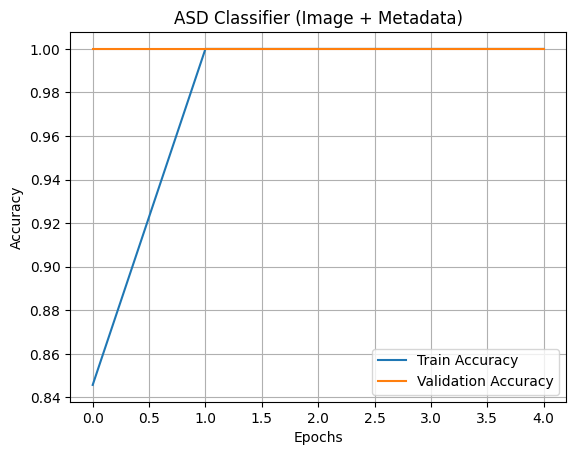

In [79]:
# 📈 Step 10: Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("ASD Classifier (Image + Metadata)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [81]:
loss, accuracy = model.evaluate([X_img_val, X_meta_val], y_val)
print(f"Final Validation Accuracy: {accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Final Validation Accuracy: 100.00%


In [85]:
# 📷 Load the image
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height))
    img = img / 255.0
    img = img.reshape(1, img_height, img_width, 1)
    return img

# 🧠 Preprocess metadata
def preprocess_metadata(age, gender, cars):
    meta = np.array([[age, gender, cars]])
    meta_scaled = scaler.transform(meta)  # Use the same scaler used earlier
    return meta_scaled

# 🧪 Predict function
def predict_asd(image_path, age, gender, cars):
    img_input = preprocess_image(image_path)
    meta_input = preprocess_metadata(age, gender, cars)

    pred = model.predict([img_input, meta_input])[0][0]

    label = "ASD (TS)" if pred > 0.5 else "Non-ASD (TC)"
    print(f"Prediction: {label} (Confidence: {pred*100:.2f}%)")

In [87]:
sample_image_path = '/content/drive/MyDrive/Images/TCImages/TC001_39.png'
predict_asd(sample_image_path, age=7, gender=1, cars=33.2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction: ASD (TS) (Confidence: 100.00%)
